<a href="https://colab.research.google.com/github/gfelekis/MSc-Dissertation/blob/master/GVI_FINAL_NOTEBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!pip install GPy

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import urllib.request
import GPy
import os
import time
import copy
import math
import tqdm
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from sklearn.model_selection import KFold

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange
from google.colab import files
%config InlineBackend.figure_format = 'svg'

In [ ]:
#@title UCI Datasets
#Boston housing dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data1 = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data1 = data1[np.random.permutation(np.arange(len(data1)))]

# Concrete compressive dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data2 = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data2 = data2[np.random.permutation(np.arange(len(data2)))]

# Energy efficiency dataset
np.random.seed(2)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data3 = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data3 = data3[np.random.permutation(np.arange(len(data3)))]

# Red wine dataset
np.random.seed(2)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data4 = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data4 = data4[np.random.permutation(np.arange(len(data4)))]

#Yacht dataset
np.random.seed(2)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data5 = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data5 = data5[np.random.permutation(np.arange(len(data5)))]

In [ ]:
torch.cuda.manual_seed_all(999)

In [ ]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [ ]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)

class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [ ]:
def tensorize(x,y):
  """ Verifies both x and y are tensors. """
  if isinstance(x, int) and not isinstance(y, int):
    x = x * torch.ones_like(y)
  elif isinstance(y, int) and not isinstance(x, int):
    y = y * torch.ones_like(x)
  return x,y

In [ ]:
class BayesLinear_Normalq(nn.Module):
  
    def __init__(self, input_dim, output_dim, prior, loss_type = "A", alpha=1.0):
        super(BayesLinear_Normalq, self).__init__()
        torch.manual_seed(42)
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.prior      = prior
        # redirect HEL and PEAR loss types to A loss and state the correct alpha
        if loss_type == "HEL":
          self.loss_type, self.alpha  = "A", 0.5
        elif loss_type == "PEAR":
          self.loss_type, self.alpha  = "A", 2.0
        else:
          self.loss_type  = loss_type
          self.alpha      = alpha
        
        #  Initialize neural network's parameters
        self.weight_mus  = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-4, -3)) #(-3,-3)
        
        self.bias_mus  = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons   =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_()) 
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos)) #softplus func
            bias_stds   = torch.log(1 + torch.exp(self.bias_rhos))   #softplus func
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample   = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the Divergence loss term

            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2

            #############
            # **0.5 is used wherever the torch.sqrt can't work since 
            # the value is not a torch.tensor
            ############

            # Kullback–Leibler Divergence
            if self.loss_type == "KL":
                loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
                loss = loss + 0.5*(varpost_cov/prior_cov).sum()
                loss = loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            # Reverse Kullback–Leibler Divergence
            elif self.loss_type == "RKL":
                loss = loss + 0.5*(torch.log(varpost_cov/prior_cov)).sum() - 0.5*prior.sigma.numel()
                loss = loss + 0.5*(prior_cov/varpost_cov).sum()
                loss = loss + 0.5*((self.prior.mu - self.weight_mus)**2/varpost_cov).sum()

            # Alpha-Renyi Divergence
            elif self.loss_type == "AR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                          (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() + \
                          0.5*(self.alpha*(self.weight_mus - self.prior.mu)**2/sigma_2).sum()
            
            # alpha-Alpha-Renyi Divergence
            elif self.loss_type == "aAR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = self.alpha*torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                          (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() + \
                          0.5*(self.alpha*(self.weight_mus - self.prior.mu)**2/sigma_2).sum()
            
            # Alpha Divergence
            elif self.loss_type == "A":
                frac = ((prior_cov**0.5)**self.alpha)*(torch.sqrt(varpost_cov)**(1-self.alpha)) \
                       /torch.sqrt(self.alpha*prior_cov + (1-self.alpha)*varpost_cov)
                exp  = torch.exp(-(self.alpha*(1-self.alpha)) * 0.5*(self.weight_mus-self.prior.mu)**2 / \
                                 (self.alpha*prior_cov + (1-self.alpha)*varpost_cov))
                loss = 1/(self.alpha*(1-self.alpha))*(1-frac*exp).sum()

            # Hellinger Distance 
            elif self.loss_type == "HEL":
                # this one is redirected at layer declaration to loss_type="A", alpha=0.5
                pass
            
            # Pearson Divergence
            elif self.loss_type == "PEAR":
                # this one is redirected at layer declaration to loss_type="A", alpha=2.0
                pass
            
            # Fisher Distance 
            elif self.loss_type == "F":
                fisher = torch.sqrt(((self.weight_mus-self.prior.mu)**2 \
                                     +2*(torch.sqrt(varpost_cov)-(prior_cov**0.5))**2)*((self.weight_mus-self.prior.mu)**2 \
                                      +2*(torch.sqrt(varpost_cov)+(prior_cov**0.5))**2))
                loss   = (2**0.5)*torch.log(fisher+(self.weight_mus-self.prior.mu)**2 \
                                        + 2*(varpost_cov + prior_cov)/(4*torch.sqrt(varpost_cov)*(prior_cov**0.5))).sum()
            
            # Jensen-Shannon Divergence
            elif self.loss_type == "JS":
                m_cov = 0.25*(prior_cov + varpost_cov) 
                m_mu  = 0.5*(self.weight_mus + self.prior.mu) 

                kl_p  = 0.5*(torch.log(prior_cov/m_cov)).sum() - 0.5*m_cov.numel()
                kl_p = kl_p + 0.5*(m_cov/prior_cov).sum()
                kl_p = kl_p + 0.5*((m_mu - self.prior.mu)**2/prior_cov).sum()

                kl_q  = 0.5*(torch.log(varpost_cov/m_cov)).sum() - 0.5*weight_stds.numel()
                kl_q = kl_q + 0.5*(m_cov/varpost_cov).sum()
                kl_q = kl_q + 0.5*((m_mu - self.weight_mus)**2/varpost_cov).sum()

                loss = 0.5*(kl_p + kl_q)
              
            # Total Variation Distance - lower bound
            elif self.loss_type == "TVL":
                torch_max = lambda x,y: torch.max(torch.stack(tensorize(x,y), dim=0))
                torch_min = lambda x,y: torch.min(torch.stack(tensorize(x,y), dim=0))

                loss = (1/200)*torch_min(1, torch_max(torch.abs(prior_cov-varpost_cov)/prior_cov, 
                                                       40*torch.abs(self.weight_mus-self.prior.mu)/prior_cov**0.5)).sum()
            # Total Variation Distance - upper bound
            elif self.loss_type == "TVU":
                loss = 3*(torch.abs(prior_cov-varpost_cov)/(2*prior_cov) + \
                      torch.abs(self.weight_mus-self.prior.mu)/2*prior_cov**0.5).sum()
                


            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2

            #Kullback–Leibler Divergence
            if self.loss_type == "KL":
                loss = loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
                loss = loss + 0.5*(varpost_cov/prior_cov).sum()
                loss = loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            #Reverse Kullback–Leibler Divergence
            elif self.loss_type == "RKL":
                loss = loss + 0.5*(torch.log(varpost_cov/prior_cov)).sum() - 0.5*prior.sigma.numel()
                loss = loss + 0.5*(prior_cov/varpost_cov).sum()
                loss = loss + 0.5*((self.prior.mu - self.bias_mus)**2/varpost_cov).sum()

            #Alpha-Renyi Divergence
            elif self.loss_type == "AR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = loss + torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                                 (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() +  \
                                 0.5*(self.alpha*(self.bias_mus - self.prior.mu)**2/sigma_2).sum()

            #alpha-Alpha-Renyi Divergence
            elif self.loss_type == "aAR":
                sigma_2 = self.alpha * prior_cov + (1-self.alpha)*varpost_cov
                loss    = loss + self.alpha*torch.log((prior_cov**0.5)/torch.sqrt(varpost_cov)).sum() + \
                                 (1/(2*(self.alpha-1)) * torch.log(prior_cov/sigma_2)).sum() +  \
                                 0.5*(self.alpha*(self.bias_mus - self.prior.mu)**2/sigma_2).sum()

            #Alpha Divergence
            elif self.loss_type == "A": 
                frac = ((prior_cov**0.5)**self.alpha)*(torch.sqrt(varpost_cov)**(1-self.alpha)) \
                       /torch.sqrt(self.alpha*prior_cov + (1-self.alpha)*varpost_cov)
                exp  = torch.exp(-(self.alpha*(1-self.alpha)) * 0.5*(self.bias_mus-self.prior.mu)**2 / \
                                 (self.alpha*prior_cov + (1-self.alpha)*varpost_cov))
                loss = loss + 1/(self.alpha*(1-self.alpha))*(1-frac*exp).sum()
            
            #Hellinger Distance 
            elif self.loss_type == "HEL":
                # this one is redirected at layer declaration to loss_type="A", alpha=0.5
                pass
            
            #Pearson Divergence
            elif self.loss_type == "PEAR":
                # this one is redirected at layer declaration to loss_type="A", alpha=2.0
                pass

            #Fisher Distance 
            elif self.loss_type == "F":
                fisher = torch.sqrt(((self.bias_mus-self.prior.mu)**2 \
                                     +2*(torch.sqrt(varpost_cov)-(prior_cov**0.5))**2)*((self.bias_mus-self.prior.mu)**2 \
                                      +2*(torch.sqrt(varpost_cov)+(prior_cov**0.5))**2))
                loss   = loss + (2**0.5)*torch.log(fisher+(self.bias_mus-self.prior.mu)**2 + \
                                            2*(varpost_cov + prior_cov)/(4*torch.sqrt(varpost_cov)*(prior_cov**0.5))).sum()
            
            #Jensen-Shannon Divergence
            elif self.loss_type == "JS":
                m_cov = 0.25*(prior_cov + varpost_cov) 
                m_mu  = 0.5*(self.bias_mus + self.prior.mu) 

                kl_p  = 0.5*(torch.log(prior_cov/m_cov)).sum() - 0.5*m_cov.numel()
                kl_p = kl_p + 0.5*(m_cov/prior_cov).sum()
                kl_p = kl_p + 0.5*((m_mu - self.prior.mu)**2/prior_cov).sum()

                kl_q  = 0.5*(torch.log(varpost_cov/m_cov)).sum() - 0.5*weight_stds.numel()
                kl_q = kl_q + 0.5*(m_cov/varpost_cov).sum()
                kl_q = kl_q + 0.5*((m_mu - self.bias_mus)**2/varpost_cov).sum()

                loss = loss + 0.5*(kl_p + kl_q)

            # Total Variation Distance - lower bound
            elif self.loss_type == "TVL":
                loss = loss + (1/200)*torch_min(1, torch_max(torch.abs(prior_cov-varpost_cov)/prior_cov, 
                                                       40*torch.abs(self.bias_mus-self.prior.mu)/prior_cov**0.5)).sum()

            # Total Variation Distance - upper bound
            elif self.loss_type == "TVU":
                loss = loss + 3*(torch.abs(prior_cov-varpost_cov)/(2*prior_cov) +\
                                torch.abs(self.bias_mus-self.prior.mu)/2*prior_cov**0.5).sum()


            return output, loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, loss

In [ ]:
class BBP_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units=[], loss_type="AR", alpha=1.0):
        super(BBP_Model_UCI, self).__init__()
        self.input_dim  = input_dim
        self.output_dim = output_dim
        self.loss_type  = loss_type
        self.alpha      = alpha 
        self.num_units  = num_units
        
        # network with two hidden and one output layer
        if len(num_units) == 1:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        if len(num_units) == 2:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], 2*output_dim, gaussian(0, 1), loss_type, alpha)
        elif len(num_units) == 3:
          self.layer1 = BayesLinear_Normalq(input_dim, num_units[0], gaussian(0, 1), loss_type, alpha)
          self.layer2 = BayesLinear_Normalq(num_units[0], num_units[1], gaussian(0, 1), loss_type, alpha)
          self.layer3 = BayesLinear_Normalq(num_units[1], num_units[2], gaussian(0, 1), loss_type, alpha)
          self.layer4 = BayesLinear_Normalq(num_units[2], 2*output_dim, gaussian(0, 1), loss_type, alpha)

        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, loss = self.layer1(x)
        loss_total = loss_total + loss
        x = self.activation(x)

        if len(self.num_units) == 1:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss

        if len(self.num_units) == 2:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss

        elif len(self.num_units) == 3:
          x, loss = self.layer2(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer3(x)
          loss_total = loss_total + loss
          x = self.activation(x)

          x, loss = self.layer4(x)
          loss_total = loss_total + loss
        
        return x, loss_total

def train_BBP(data, n_splits, num_epochs, num_units, learn_rate, log_every, loss_type="AR", alpha=1.0):
    torch.manual_seed(42)
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []
    total_loss_accross_splits = []

    for i, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % i)
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        # Normilising the data
        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test  = (x_test - x_means)/x_stds
        y_test  = (y_test - y_means)/y_stds

        batch_size, nb_train = len(x_train), len(x_train)

        model = BBP_Model_UCI(x_test.shape[-1], output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
        
        net   = BBP_Model_Wrapper(model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

        fit_loss_train = np.zeros(num_epochs)
        loss_train     = np.zeros(num_epochs)
        total_loss     = np.zeros(num_epochs)

        best_net, best_loss = None, float('inf')

        loss_evolution = []
        for i in range(num_epochs):
            fit_loss, loss, total_loss_record  = net.fit(x_train, y_train, no_samples = 100)
            fit_loss_train[i] += fit_loss.cpu().data.numpy()
            loss_train[i]     += loss.cpu().data.numpy()
            # record total loss for training curve display
            loss_evolution.append(total_loss_record)

            total_loss[i] = fit_loss_train[i] + loss_train[i]

            if fit_loss < best_loss:
                best_loss = fit_loss
                best_net  = copy.deepcopy(net.network)

            if i % log_every == 0 or i == num_epochs - 1:

                train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
                test_losses, test_rmse   = net.get_loss_and_rmse(x_test, y_test, 20)

                print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                      (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                       -test_losses.mean() - np.log(y_stds)[0], y_stds*train_rmse, y_stds*test_rmse))

        # record loss evlution
        total_loss_accross_splits.append(loss_evolution.copy())

        train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
        test_losses, test_rmse   = net.get_loss_and_rmse(x_test, y_test, 20)

        train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
        test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

        train_rmses.append(y_stds*train_rmse)
        test_rmses.append(y_stds*test_rmse)

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))

    rmses =  list(np.array(test_rmses).flatten())
    print("Test LogLike for different folds: ", test_logliks)
    print("Test RMSEs   for different folds: ", rmses)

    metrics = {"train_log_like_mean": -np.array(train_logliks).mean(), "train_log_like_var": np.array(train_logliks).var()**0.5,
               "test_log_like_mean": -np.array(test_logliks).mean(), "test_log_like_var": np.array(test_logliks).var()**0.5,
               "train_rmse_mean": np.array(train_rmses).mean(), "train_rmse_var": np.array(train_rmses).var()**0.5,
               "test_rmse_mean": np.array(test_rmses).mean(), "test_rmse_var":np.array(test_rmses).var()**0.5,
               "rmse_values": list(np.array(test_rmses).flatten()),
               "loglik_values": list(np.array(test_logliks).flatten()),
               "total_loss_accross_splits": list(np.array(total_loss_accross_splits).flatten())}

    return best_net, metrics

In [ ]:
class BBP_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        torch.manual_seed(42)
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss       = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        loss_total = loss_total/self.no_batches # Divergence loss 
        total_loss = (fit_loss_total + loss_total)/(no_samples*x.shape[0])
        #total_loss = (fit_loss_total/no_samples + loss_total)/(x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, loss_total, total_loss.cpu().detach().numpy()
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, loss_total = self.network(x)
            means.append(output[:, :1, None]) 
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std  = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

## RUNNING THE EXPERIMENTS

In [ ]:
# set up the access to drive - we'll be saving our logs there
from google.colab import drive
drive.mount("/content/drive")
# define paths for the different experiments
alpha_path = "/content/drive/My Drive/"+"alpha_gridsearch_logs.txt"
grid_path  = "/content/drive/My Drive/"+"div_gridsearch_logs.txt"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Grid Search for Alpha and Alpha-Renyi divergences

In [ ]:
logs_alpha = []
### some params
n_splits = 30
n_epochs = 100
hidden   = 100
models, log_metrics = [], []

### alphas_experiment
losses  = ["A", "AR", "aAR"]
dataset = [data1, data2, data3, data4, data5] # list of all the datasets
dataset_names = ["Boston", "Concrete", "Energy", "Wine", "Yacht"]
alphas  = [0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0] 
hiddens = [1]
for loss in losses:
  print("Divergence ==", loss)
  for alpha in alphas:
    print("Alpha ==", alpha)
    i = 0
    for data in dataset:
      dataset_name = dataset_names[i]
      for h in hiddens:
        # run the training
        num_units = [hidden for i in range(h)]
        model, metric = train_BBP(data, n_splits=n_splits, num_epochs=n_epochs, num_units=num_units,
                                  learn_rate=1e-2, log_every=10, loss_type=loss, alpha=alpha)
        models.append(model)
        # record to file: 
        log = {"dataset": dataset_name,
               "loss": loss,
               "alpha": alpha,
               "n_layers": h, 
               "constant_hidden_size": hidden, 
               "metrics": metric}
        logs_alpha.append(log)
      i += 1
      with open(alpha_path, "a") as f:
          f.write(str(log)+"\n")
          print(log)

Test of the performance of different divergences - GVI Vs VI

In [ ]:
logs_grid = []
### some params
n_splits = 30
n_epochs = 100
hidden   = 100
### alphas_experiment
loss2alpha = {"A": 2.75, "AR": 2.0, "aAR": 2.5}
losses  = ["KL", "RKL", "JS", "F", "TVL", "TVU", "A", "AR", "aAR"]
dataset = [data2, data3, data5] # list of all the datasets
dataset_names = ["Concrete", "Energy", "Yacht"]
hiddens = [1, 2, 3]
models, log_metrics = [], []
for loss in losses:
  alpha = loss2alpha[loss] if loss in loss2alpha.keys() else 1.0
  print("Divergence ==", loss)
  i = 0
  for data in dataset:
    dataset_name = dataset_names[i]
    for h in hiddens:
      # run the training
      num_units = [hidden for i in range(h)]
      model, metric = train_BBP(data, n_splits=n_splits, num_epochs=n_epochs, num_units=num_units,
                                  learn_rate=1e-2, log_every=10, loss_type=loss, alpha=alpha)
      models.append(model)
      # record to file: 
      log = {"dataset": dataset_name,
             "loss": loss,
             "alpha": alpha,
             "n_layers": h, 
             "constant_hidden_size": hidden, 
             "metrics": metric}
      logs_grid.append(log)
      with open(grid_path, "a") as f:
        f.write(str(log)+"\n")
      print(log)
    i += 1


# Aleatoric and Epistemic uncertainty

Plotting functions

In [ ]:
def plot_uncertainty(net, x, y, std, mean, loss):
  samples, noises = [], []
  for i in range(100):
      preds = net.forward(torch.linspace(-5, 5, 200).cuda())[0]
      samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
      noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

  samples = np.array(samples)
  noises = np.array(noises)
  means = samples.mean(axis = 0)

  aleatoric = (noises**2).mean(axis = 0)**0.5
  epistemic = samples.var(axis = 0)**0.5
  aleatoric = np.minimum(aleatoric, 10e3)
  epistemic = np.minimum(epistemic, 10e3)

  total_unc = (aleatoric**2 + epistemic**2)**0.5

  c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

  x_mean, x_std = x_train.mean(), x_train.var()**0.5
  plt.figure(figsize = (5, 4))
  plt.style.use('default')
  plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
  plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[4], alpha = 0.4, label = 'Aleatoric')
  plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
  plt.xlim([-5, 5])
  plt.ylim([-5, 7])
  plt.xlabel('$x$', fontsize=10)
  plt.title(str(loss), fontsize=20)
  plt.tick_params(labelsize=10)
  plt.xticks(np.arange(-4, 5, 2))
  plt.yticks(np.arange(-4, 7, 2))
  plt.gca().set_yticklabels([])
  plt.gca().yaxis.grid(alpha=0.3)
  plt.gca().xaxis.grid(alpha=0.3)
  plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')


  plt.show()

In [ ]:
def plot_uncertainty_3row(nets, x, y, std, mean, loss):
  fig, ax = plt.subplots(1, 3, figsize=(15, 4))
  fig.suptitle(loss + " h=1 | h=2 | h=3")
  for n, net in enumerate(nets):
    samples, noises = [], []
    for i in range(100):
        preds = nets[n].network.forward(torch.linspace(-5, 5, 200).cuda())[0]
        samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
        noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

    samples = np.array(samples)
    noises = np.array(noises)
    means = samples.mean(axis = 0)

    aleatoric = (noises**2).mean(axis = 0)**0.5
    epistemic = samples.var(axis = 0)**0.5
    aleatoric = np.minimum(aleatoric, 10e3)
    epistemic = np.minimum(epistemic, 10e3)

    total_unc = (aleatoric**2 + epistemic**2)**0.5

    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    x_mean, x_std = x_train.mean(), x_train.var()**0.5
    ax[n].scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    ax[n].fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[4], alpha = 0.4, label = 'Aleatoric')
    ax[n].plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
    ax[n].set_xlim([-5, 5])
    ax[n].set_ylim([-5, 7])
    ax[n].set_xlabel('$x$', fontsize=10)
    ax[n].set_title("h = "+str(n+1), fontsize=10)
    ax[n].tick_params(labelsize=10)
    ax[n].set_xticks(np.arange(-4, 5, 2))
    ax[n].set_yticks(np.arange(-4, 7, 2))
    plt.gca().set_yticklabels([])
    ax[n].grid(alpha=0.3)

  plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')
  plt.show()

Information Criteria for Model selection


In [ ]:
# Akaike’s Information Criterion
def aic(y, y_pred, p):
    n = len(y)
    resid = np.subtract(y_pred, y)
    rss = np.sum(np.power(resid, 2))
    aic_score = n*np.log(rss/n) + 2*p
    return aic_score

# Bayesian Information Criterion
def bic(y, y_pred, p):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    bic_score = n*np.log(SSE/n) + p*np.log(n)
    return bic_score

# Hannan–Quinn Information Criterion
def hqc(y, y_pred, p):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    hqc_score = n*np.log(SSE/n) + 2*p*np.log(np.log(n))
    return hqc_score

# Log-likelihood Information Criterion
def llc(y, y_pred):
    n = len(y)
    residual = np.subtract(y_pred, y)
    SSE = np.sum(np.power(residual, 2))
    llc_score = n*np.log(SSE/n) 
    return llc_score

Heteroscedastic data

In [ ]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std


losses       = ["KL", "RKL", "JS", "TVL", "TVU", "F", "A", "AR", "aAR"]
losses_names = ["KL Divergence", "Reverse KL Divergence", "Jensen–Shannon Divergence",
                "Total Variation Distance (lower bound)", "Total Variation Distance (upper bound)",
                "Fisher Distance", "Alpha Divergence", "Alpha Renyi Divergence", "parametrized Alpha Renyi Divergence"]
loss2alpha = {"A": 2.75, "AR": 2.0, "aAR": 2.5} 
name = 0
for loss in losses:
  alpha = loss2alpha[loss] if loss in loss2alpha.keys() else 1.0
  num_epochs, batch_size, nb_train = 500, len(x_train), len(x_train) 
  loss_type= loss

  # best_nets stores the networks for the different hidden layer numbers
  best_nets = []
  for num_units in [[100], [100, 200], [100, 200, 100]]: 
    model = BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
    net   = BBP_Model_Wrapper(network=model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

    fit_loss_train = np.zeros(num_epochs)
    div_loss_train = np.zeros(num_epochs)
    total_loss = np.zeros(num_epochs)

    best_net, best_loss = None, float('inf')

    for i in range(num_epochs):
        
        fit_loss, div_loss = net.fit(x_train, y_train, no_samples = 10)
        fit_loss_train[i] += fit_loss.cpu().data.numpy()
        div_loss_train[i] += div_loss.cpu().data.numpy()
        
        total_loss[i] = fit_loss_train[i] + div_loss_train[i]
        
        if fit_loss < best_loss:
            best_loss = fit_loss
            best_net = copy.deepcopy(net)
            
        if i % 100 == 0 or i == num_epochs - 1:
            print("Epoch: {0}/{1}, Fit loss = {2}, {3} loss = {4}".format(
                  i+1,num_epochs, fit_loss_train[i], loss_type, div_loss_train[i]))
            samples = []
            for i in range(100):
                preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
                samples.append(preds.cpu().data.numpy()[:, 0])

    train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
    # test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

    train_loglik = train_losses.cpu().data.numpy().mean() + np.log(y_std)
    # test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

    print("Train RMSE = ", train_rmse)
    print("Train Log-likelihood = ", train_loglik)
    # print("test loglike:", test)
    #train_rmses.append(y_stds*train_rmse)
    #test_rmses.append(y_stds*test_rmse)
    best_nets.append(copy.deepcopy(best_net))
  plot_uncertainty_3row(best_nets, x_train, y_train, y_std, y_mean, losses_names[name])

  # convert x_train to cuda for the predictions
  x_for_pred = to_variable(var=(x_train,), cuda=True)[0]

  for i in range(len(best_nets)):
    p = sum([x.numel() for x in best_nets[i].network.parameters()])
    y_pred, loss_pred = best_nets[0].network.forward(x_for_pred)
    y_pred = y_pred.cpu().detach().numpy().astype(float)
    print("AIC for layers =", i+1, "is:", aic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("BIC for layers =", i+1, "is:", bic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("HQC for layers =", i+1, "is:", hqc(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("LLC for layers =", i+1, "is:", llc(y_train.flatten().astype(float), y_pred[:, 0].flatten()))
    print()
  name += 1

Homoscedastic data

Epoch: 1/500, Fit loss = 354.6701354980469, KL loss = 533.5700073242188
Epoch: 101/500, Fit loss = 87.9326400756836, KL loss = 497.10418701171875
Epoch: 201/500, Fit loss = -0.8694267272949219, KL loss = 542.69189453125
Epoch: 301/500, Fit loss = -36.543113708496094, KL loss = 560.4375
Epoch: 401/500, Fit loss = -42.77159881591797, KL loss = 562.7435302734375
Epoch: 500/500, Fit loss = -39.621681213378906, KL loss = 559.2666015625
Train RMSE =  0.19617199897766113
Train Log-likelihood =  0.2533949687179789
Epoch: 1/500, Fit loss = 355.0135498046875, KL loss = 13722.0341796875
Epoch: 101/500, Fit loss = 71.0090103149414, KL loss = 9263.669921875
Epoch: 201/500, Fit loss = -2.563502073287964, KL loss = 6004.25537109375
Epoch: 301/500, Fit loss = -2.8052971363067627, KL loss = 3751.04541015625
Epoch: 401/500, Fit loss = -17.05692481994629, KL loss = 2515.88916015625
Epoch: 500/500, Fit loss = -22.60297203063965, KL loss = 1918.430419921875
Train RMSE =  0.19981710612773895
Train Log-likel

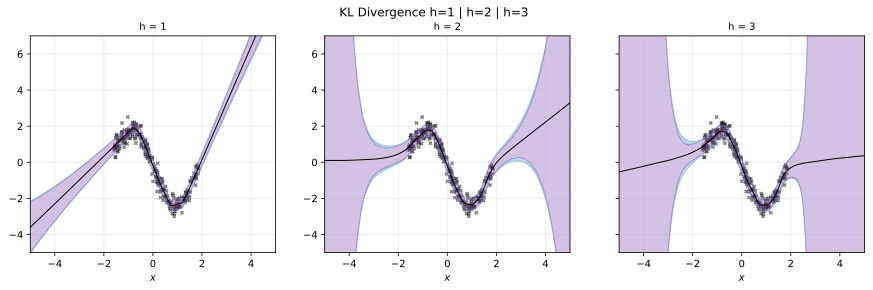

Epoch: 1/500, Fit loss = 355.48553466796875, RKL loss = 72638.609375
Epoch: 101/500, Fit loss = 217.15367126464844, RKL loss = 16953.775390625
Epoch: 201/500, Fit loss = 223.2276611328125, RKL loss = 8058.5751953125
Epoch: 301/500, Fit loss = 184.2745819091797, RKL loss = 5051.1396484375
Epoch: 401/500, Fit loss = 219.55078125, RKL loss = 3688.903076171875
Epoch: 500/500, Fit loss = 207.07078552246094, RKL loss = 2969.767333984375
Train RMSE =  0.34804224967956543
Train Log-likelihood =  1.093706570475982
Epoch: 1/500, Fit loss = 354.8163757324219, RKL loss = 1184600.25
Epoch: 101/500, Fit loss = 291.4306640625, RKL loss = 273278.25
Epoch: 201/500, Fit loss = 198.766357421875, RKL loss = 126785.9296875
Epoch: 301/500, Fit loss = 205.38548278808594, RKL loss = 74970.9453125
Epoch: 401/500, Fit loss = 188.9773712158203, RKL loss = 50053.03125
Epoch: 500/500, Fit loss = 203.47813415527344, RKL loss = 36088.13671875
Train RMSE =  0.33743616938591003
Train Log-likelihood =  0.83872320494024

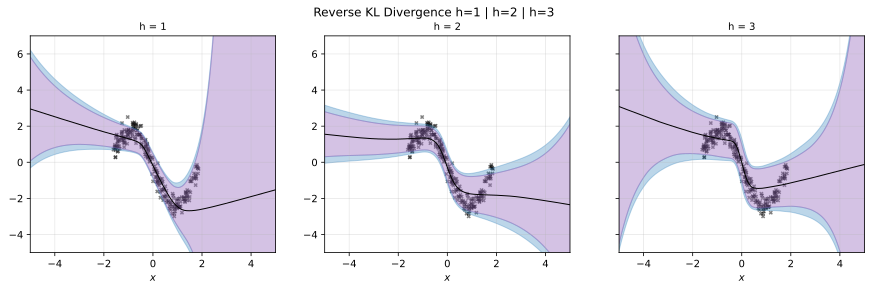

Epoch: 1/500, Fit loss = 355.0177001953125, JS loss = 8246.4638671875
Epoch: 101/500, Fit loss = 189.30410766601562, JS loss = 1929.7666015625
Epoch: 201/500, Fit loss = 125.87303924560547, JS loss = 1220.78515625
Epoch: 301/500, Fit loss = 77.63092803955078, JS loss = 1047.4169921875
Epoch: 401/500, Fit loss = 76.75119018554688, JS loss = 962.1083984375
Epoch: 500/500, Fit loss = 74.0155258178711, JS loss = 895.3465576171875
Train RMSE =  0.24837003648281097
Train Log-likelihood =  0.6109938993152841
Epoch: 1/500, Fit loss = 355.2079162597656, JS loss = 142481.234375
Epoch: 101/500, Fit loss = 130.85227966308594, JS loss = 30643.62890625
Epoch: 201/500, Fit loss = 126.00585174560547, JS loss = 13286.8330078125
Epoch: 301/500, Fit loss = 132.39743041992188, JS loss = 7413.72021484375
Epoch: 401/500, Fit loss = 124.6787109375, JS loss = 4743.7158203125
Epoch: 500/500, Fit loss = 87.91153717041016, JS loss = 3312.079833984375
Train RMSE =  0.25141212344169617
Train Log-likelihood =  0.72

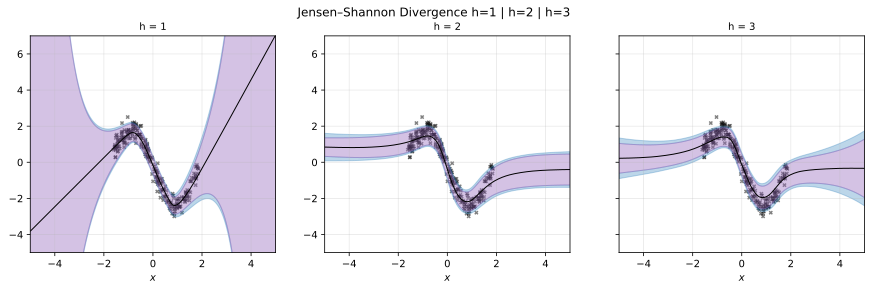

Epoch: 1/500, Fit loss = 354.61627197265625, TVL loss = 0.019972877576947212
Epoch: 101/500, Fit loss = 143.35919189453125, TVL loss = 0.019999999552965164
Epoch: 201/500, Fit loss = -26.8879451751709, TVL loss = 0.019999999552965164
Epoch: 301/500, Fit loss = -47.449317932128906, TVL loss = 0.019999999552965164
Epoch: 401/500, Fit loss = -47.92128372192383, TVL loss = 0.019999999552965164
Epoch: 500/500, Fit loss = -50.73325729370117, TVL loss = 0.019999999552965164
Train RMSE =  0.19590473175048828
Train Log-likelihood =  0.29733438035814613
Epoch: 1/500, Fit loss = 355.5324401855469, TVL loss = 0.02995707094669342
Epoch: 101/500, Fit loss = 17.275493621826172, TVL loss = 0.029999999329447746
Epoch: 201/500, Fit loss = -25.137401580810547, TVL loss = 0.029999999329447746
Epoch: 301/500, Fit loss = -38.9043083190918, TVL loss = 0.029999999329447746
Epoch: 401/500, Fit loss = -36.142120361328125, TVL loss = 0.029999999329447746
Epoch: 500/500, Fit loss = -45.46808624267578, TVL loss = 

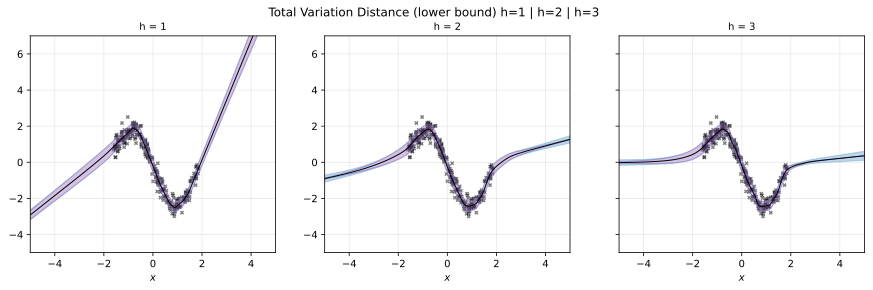

Epoch: 1/500, Fit loss = 354.96417236328125, TVU loss = 303.8035888671875
Epoch: 101/500, Fit loss = 54.36735153198242, TVU loss = 369.60089111328125
Epoch: 201/500, Fit loss = -34.77621078491211, TVU loss = 376.91241455078125
Epoch: 301/500, Fit loss = -42.960018157958984, TVU loss = 376.77056884765625
Epoch: 401/500, Fit loss = -47.52431869506836, TVU loss = 375.9850158691406
Epoch: 500/500, Fit loss = -51.07215118408203, TVU loss = 375.140380859375
Train RMSE =  0.19602805376052856
Train Log-likelihood =  0.22548044463960976
Epoch: 1/500, Fit loss = 355.058837890625, TVU loss = 8124.4111328125
Epoch: 101/500, Fit loss = -5.385345935821533, TVU loss = 8342.333984375
Epoch: 201/500, Fit loss = -27.039031982421875, TVU loss = 8263.4912109375
Epoch: 301/500, Fit loss = -44.08357620239258, TVU loss = 7735.3623046875
Epoch: 401/500, Fit loss = -43.290855407714844, TVU loss = 6867.79931640625
Epoch: 500/500, Fit loss = -47.12194061279297, TVU loss = 6082.7021484375
Train RMSE =  0.19681471

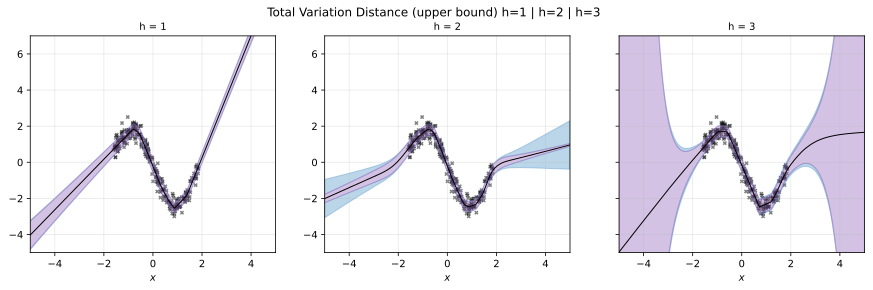

Epoch: 1/500, Fit loss = 353.7113342285156, F loss = 747.0558471679688
Epoch: 101/500, Fit loss = 73.50314331054688, F loss = 701.8177490234375
Epoch: 201/500, Fit loss = -1.9834699630737305, F loss = 742.2274169921875
Epoch: 301/500, Fit loss = -23.8466739654541, F loss = 758.8778076171875
Epoch: 401/500, Fit loss = -39.2298698425293, F loss = 760.8411865234375
Epoch: 500/500, Fit loss = -42.54549789428711, F loss = 752.970703125
Train RMSE =  0.20333781838417053
Train Log-likelihood =  0.24220211049883217
Epoch: 1/500, Fit loss = 355.5997009277344, F loss = 19261.986328125
Epoch: 101/500, Fit loss = 44.551353454589844, F loss = 14453.490234375
Epoch: 201/500, Fit loss = 23.465499877929688, F loss = 11876.0263671875
Epoch: 301/500, Fit loss = -2.6465234756469727, F loss = 10093.298828125
Epoch: 401/500, Fit loss = -14.769052505493164, F loss = 6591.61376953125
Epoch: 500/500, Fit loss = -6.992946147918701, F loss = 4327.40234375
Train RMSE =  0.19936010241508484
Train Log-likelihood =

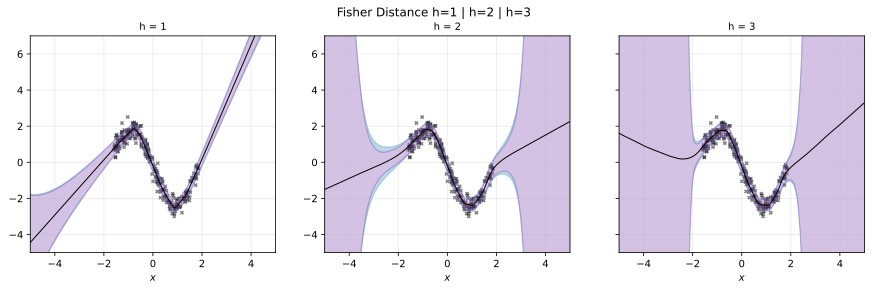

Epoch: 1/500, Fit loss = 355.140869140625, A loss = 569.5715942382812
Epoch: 101/500, Fit loss = 121.79811096191406, A loss = 561.7156982421875
Epoch: 201/500, Fit loss = -5.173889636993408, A loss = 593.2230224609375
Epoch: 301/500, Fit loss = -30.910634994506836, A loss = 602.62890625
Epoch: 401/500, Fit loss = -43.23641586303711, A loss = 603.285400390625
Epoch: 500/500, Fit loss = -45.69453811645508, A loss = 599.6607666015625
Train RMSE =  0.19693788886070251
Train Log-likelihood =  0.249525315969871
Epoch: 1/500, Fit loss = 355.0708923339844, A loss = 14919.5986328125
Epoch: 101/500, Fit loss = 32.56614303588867, A loss = 11328.1171875
Epoch: 201/500, Fit loss = 1.6174602508544922, A loss = 6972.17333984375
Epoch: 301/500, Fit loss = 4.497230052947998, A loss = 3860.645751953125
Epoch: 401/500, Fit loss = -7.338069915771484, A loss = 2542.48193359375
Epoch: 500/500, Fit loss = -24.340272903442383, A loss = 1963.77978515625
Train RMSE =  0.2055247575044632
Train Log-likelihood =  

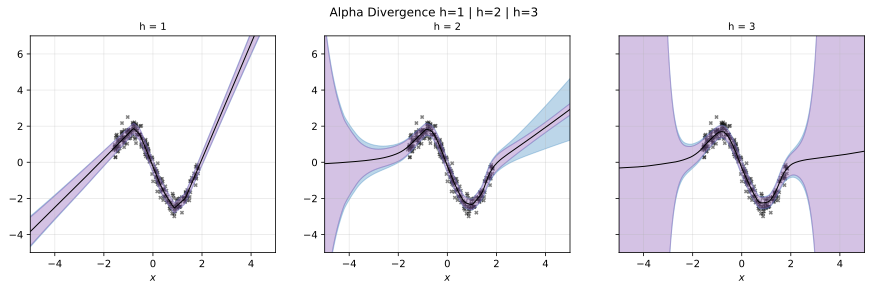

Epoch: 1/500, Fit loss = 354.66827392578125, AR loss = 496.5689392089844
Epoch: 101/500, Fit loss = 97.62323760986328, AR loss = 464.9901123046875
Epoch: 201/500, Fit loss = -25.12118148803711, AR loss = 511.017822265625
Epoch: 301/500, Fit loss = -25.555692672729492, AR loss = 523.253173828125
Epoch: 401/500, Fit loss = -37.347164154052734, AR loss = 525.2763061523438
Epoch: 500/500, Fit loss = -35.090797424316406, AR loss = 524.103271484375
Train RMSE =  0.19666041433811188
Train Log-likelihood =  0.2235117181238398
Epoch: 1/500, Fit loss = 355.1618347167969, AR loss = 12685.0556640625
Epoch: 101/500, Fit loss = 16.81512451171875, AR loss = 8255.4189453125
Epoch: 201/500, Fit loss = -0.17111721634864807, AR loss = 5121.10693359375
Epoch: 301/500, Fit loss = -7.786282539367676, AR loss = 3144.667236328125
Epoch: 401/500, Fit loss = -16.718427658081055, AR loss = 2152.13525390625
Epoch: 500/500, Fit loss = -19.42058753967285, AR loss = 1665.272216796875
Train RMSE =  0.2026769816875457

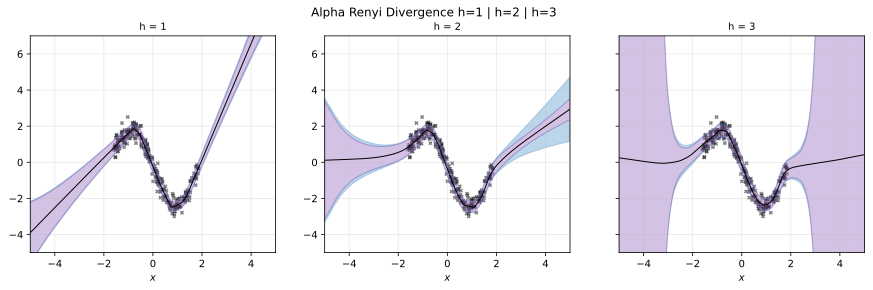

Epoch: 1/500, Fit loss = 354.5078125, aAR loss = 176.9483642578125
Epoch: 101/500, Fit loss = 112.87178802490234, aAR loss = 179.679931640625
Epoch: 201/500, Fit loss = -21.0639591217041, aAR loss = 211.1228790283203
Epoch: 301/500, Fit loss = -32.8166618347168, aAR loss = 222.2654266357422
Epoch: 401/500, Fit loss = -40.26005172729492, aAR loss = 228.7242431640625
Epoch: 500/500, Fit loss = -49.37213134765625, aAR loss = 230.49887084960938
Train RMSE =  0.19688567519187927
Train Log-likelihood =  0.23294051727621407
Epoch: 1/500, Fit loss = 354.7876892089844, aAR loss = 4474.08544921875
Epoch: 101/500, Fit loss = 62.136444091796875, aAR loss = 2486.89208984375
Epoch: 201/500, Fit loss = 10.109557151794434, aAR loss = 1247.576171875
Epoch: 301/500, Fit loss = -13.364694595336914, aAR loss = 575.564697265625
Epoch: 401/500, Fit loss = -27.516611099243164, aAR loss = 270.1089782714844
Epoch: 500/500, Fit loss = -26.902063369750977, aAR loss = 111.16028594970703
Train RMSE =  0.2000465989

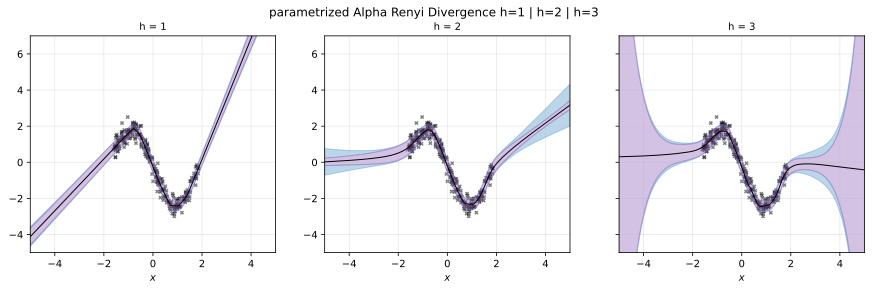

In [ ]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

x_mean, x_std = x_train.mean(), x_train.var()**0.5
y_mean, y_std = y_train.mean(), y_train.var()**0.5

x_train = (x_train - x_mean)/x_std
y_train = (y_train - y_mean)/y_std

losses       = ["KL", "RKL", "JS", "TVL", "TVU", "F", "A", "AR", "aAR"]
losses_names = ["KL Divergence", "Reverse KL Divergence", "Jensen–Shannon Divergence",
                "Total Variation Distance (lower bound)", "Total Variation Distance (upper bound)",
                "Fisher Distance", "Alpha Divergence", "Alpha Renyi Divergence", "parametrized Alpha Renyi Divergence"]
name = 0
for loss in losses:
  num_epochs, batch_size, nb_train = 500, len(x_train), len(x_train) 
  loss_type, alpha = loss, 0.5

  # best_nets stores the networks for the different hidden layer numbers
  best_nets = []
  for num_units in [[50], [50, 100], [50, 100, 50]]: # num_units = [50] 
    model = BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=num_units, loss_type=loss_type, alpha=alpha)
    net   = BBP_Model_Wrapper(network=model, learn_rate=1e-2, batch_size=batch_size, no_batches=1)

    fit_loss_train = np.zeros(num_epochs)
    div_loss_train = np.zeros(num_epochs)
    total_loss = np.zeros(num_epochs)

    best_net, best_loss = None, float('inf')

    for i in range(num_epochs):
        
        fit_loss, div_loss = net.fit(x_train, y_train, no_samples = 10)
        fit_loss_train[i] += fit_loss.cpu().data.numpy()
        div_loss_train[i] += div_loss.cpu().data.numpy()
        
        total_loss[i] = fit_loss_train[i] + div_loss_train[i]
        
        if fit_loss < best_loss:
            best_loss = fit_loss
            best_net = copy.deepcopy(net)
            
        if i % 100 == 0 or i == num_epochs - 1:
            print("Epoch: {0}/{1}, Fit loss = {2}, {3} loss = {4}".format(
                  i+1,num_epochs, fit_loss_train[i], loss_type, div_loss_train[i]))
            samples = []
            for i in range(100):
                preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
                samples.append(preds.cpu().data.numpy()[:, 0])

    train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
    # test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

    train_loglik = train_losses.cpu().data.numpy().mean() + np.log(y_std)
    # test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

    print("Train RMSE = ", train_rmse)
    print("Train Log-likelihood = ", train_loglik)
    # print("test loglike:", test)
    #train_rmses.append(y_stds*train_rmse)
    #test_rmses.append(y_stds*test_rmse)
    best_nets.append(copy.deepcopy(best_net))
  plot_uncertainty_3row(best_nets, x_train, y_train, y_std, y_mean, losses_names[name])
  
  # convert x_train to cuda for the predictions
  x_for_pred = to_variable(var=(x_train,), cuda=True)[0]

  for i in range(len(best_nets)):
    p = sum([x.numel() for x in best_nets[i].network.parameters()])
    y_pred, loss_pred = best_nets[0].network.forward(x_for_pred)
    y_pred = y_pred.cpu().detach().numpy().astype(float)
    print("AIC for layers =", i+1, "is:", aic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("BIC for layers =", i+1, "is:", bic(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print("HQC for layers =", i+1, "is:", hqc(y_train.flatten().astype(float), y_pred[:, 0].flatten(), p))
    print()
  name += 1